### EDA & Vintage Analysis

**Vintage analysis** is a widely-used method for managing credit risk, it illustrate the behavior after an account was opened. Based on same origination period, it calculates charge-off ratio of a loan portfolio.

**Here comes our datasets, in which credit_record.csv contains loan accounts' credit records**

while the **application_record.csv** contains appliers' features, such as gender, income. This notebook will show some necessary EDA on credit_record table.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd    
import matplotlib.pyplot as plt
#!pip install lifelines
from lifelines import NelsonAalenFitter, CoxPHFitter, KaplanMeierFitter
from lifelines.statistics import logrank_test

In [3]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)
credit = pd.read_csv('/Users/Asus/Documents/Atmel Studio/Analysis/credit_record.csv')  
application = pd.read_csv('/Users/Asus/Documents/Atmel Studio/Analysis/application_record.csv') 
credit

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C
...,...,...,...
1048570,5150487,-25,C
1048571,5150487,-26,C
1048572,5150487,-27,C
1048573,5150487,-28,C


In [4]:
application.head(10)


,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
5,5008810,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
6,5008811,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
7,5008812,F,N,Y,0,283500.0,Pensioner,Higher education,Separated,House / apartment,-22464,365243,1,0,0,0,NaN,1.0
8,5008813,F,N,Y,0,283500.0,Pensioner,Higher education,Separated,House / apartment,-22464,365243,1,0,0,0,NaN,1.0
9,5008814,F,N,Y,0,283500.0,Pensioner,Higher education,Separated,House / apartment,-22464,365243,1,0,0,0,NaN,1.0


In [5]:
len(set(application['ID'])) # how many unique ID in application record?

438510

In [6]:
len(set(credit['ID'])) # how many unique ID in credit record?


45985

In [7]:
len(set(application['ID']).intersection(set(credit['ID']))) # how many IDs do two tables share?

36457

### Vintage Analysis
Detailed explanation could be seen here here.

In [8]:
grouped = credit.groupby('ID')
### convert credit data to wide format which every ID is a row
pivot_tb = credit.pivot(index = 'ID', columns = 'MONTHS_BALANCE', values = 'STATUS')
pivot_tb['open_month'] = grouped['MONTHS_BALANCE'].min() # smallest value of MONTHS_BALANCE, is the month when loan was granted
pivot_tb['end_month'] = grouped['MONTHS_BALANCE'].max() # biggest value of MONTHS_BALANCE, might be observe over or canceling account
pivot_tb['ID'] = pivot_tb.index
pivot_tb = pivot_tb[['ID', 'open_month', 'end_month']]
pivot_tb['window'] = pivot_tb['end_month'] - pivot_tb['open_month'] # calculate observe window
pivot_tb.reset_index(drop = True, inplace = True)
credit = pd.merge(credit, pivot_tb, on = 'ID', how = 'left') 

In [9]:
# join calculated information
credit0 = credit.copy()
credit = credit[credit['window'] > 20] # delete users whose observe window less than 20
credit['status'] = np.where((credit['STATUS'] == '2') | (credit['STATUS'] == '3' )| (credit['STATUS'] == '4' )| (credit['STATUS'] == '5'), 1, 0) # analyze > 60 days past due 
credit['status'] = credit['status'].astype(np.int8) # 1: overdue 0: not
credit['month_on_book'] = credit['MONTHS_BALANCE'] - credit['open_month'] # calculate month on book: how many months after opening account
credit.sort_values(by = ['ID','month_on_book'], inplace = True)

In [10]:
##### denominator
denominator = pivot_tb.groupby(['open_month']).agg({'ID': ['count']}) # count how many users in every month the account was opened
denominator.reset_index(inplace = True)
denominator.columns = ['open_month','sta_sum']

##### ventage table
vintage = credit.groupby(['open_month','month_on_book']).agg({'ID': ['count']}) 
vintage.reset_index(inplace = True)
vintage.columns = ['open_month','month_on_book','sta_sum'] 
vintage['due_count'] = np.nan
vintage = vintage[['open_month','month_on_book','due_count']] # delete aggerate column
vintage = pd.merge(vintage, denominator, on = ['open_month'], how = 'left') # join sta_sum colun to vintage table
vintage

,open_month,month_on_book,due_count,sta_sum
0,-60,0,NaN,415
1,-60,1,NaN,415
2,-60,2,NaN,415
3,-60,3,NaN,415
4,-60,4,NaN,415
...,...,...,...,...
1655,-21,17,NaN,858
1656,-21,18,NaN,858
1657,-21,19,NaN,858
1658,-21,20,NaN,858


In [11]:
for j in range(-60,1): # outer loop: month in which account was opened
    ls = []
    for i in range(0,61): # inner loop time after the credit card was granted
        due = list(credit[(credit['status'] == 1) & (credit['month_on_book'] == i) & (credit['open_month'] == j)]['ID']) # get ID which satisfy the condition
        ls.extend(due) # As time goes, add bad customers
        vintage.loc[(vintage['month_on_book'] == i) & (vintage['open_month'] == j), 'due_count'] = len(set(ls)) # calculate non-duplicate ID numbers using set()
        
vintage['sta_rate']  = vintage['due_count'] / vintage['sta_sum'] # calculate cumulative % of bad customers
vintage     

,open_month,month_on_book,due_count,sta_sum,sta_rate
0,-60,0,0.0,415,0.000000
1,-60,1,0.0,415,0.000000
2,-60,2,0.0,415,0.000000
3,-60,3,0.0,415,0.000000
4,-60,4,0.0,415,0.000000
...,...,...,...,...,...
1655,-21,17,15.0,858,0.017483
1656,-21,18,15.0,858,0.017483
1657,-21,19,15.0,858,0.017483
1658,-21,20,15.0,858,0.017483


**Using pivot to convert long data to wide data:**

In [12]:
### Vintage wide table
vintage_wide = vintage.pivot(index = 'open_month',
                             columns = 'month_on_book',
                             values = 'sta_rate')
vintage_wide

month_on_book,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60
open_month,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
-60,0.00000,0.000000,0.000000,0.000000,0.000000,0.002410,0.002410,0.007229,0.007229,0.009639,0.009639,0.012048,0.014458,0.016867,0.016867,0.016867,0.016867,0.016867,0.016867,0.016867,0.016867,0.019277,0.019277,0.019277,0.019277,0.021687,0.021687,0.021687,0.021687,0.024096,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.028916,0.028916,0.028916,0.028916,0.028916,0.028916,0.028916,0.028916,0.031325,0.031325,0.031325
-59,0.00000,0.000000,0.000000,0.004926,0.004926,0.004926,0.007389,0.007389,0.007389,0.012315,0.012315,0.019704,0.019704,0.019704,0.019704,0.019704,0.019704,0.019704,0.022167,0.024631,0.024631,0.027094,0.027094,0.027094,0.027094,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.032020,0.032020,0.032020,0.032020,0.032020,0.032020,NaN
-58,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.004545,0.006818,0.006818,0.011364,0.013636,0.013636,0.013636,0.013636,0.013636,0.013636,0.015909,0.018182,0.018182,0.018182,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,NaN,NaN
-57,0.00000,0.000000,0.000000,0.000000,0.002500,0.002500,0.002500,0.007500,0.007500,0.007500,0.007500,0.007500,0.010000,0.017500,0.017500,0.017500,0.017500,0.017500,0.017500,0.017500,0.017500,0.017500,0.017500,0.017500,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.022500,0.022500,0.022500,0.022500,0.022500,0.022500,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,NaN,NaN,NaN
-56,0.00000,0.000000,0.004255,0.004255,0.008511,0.010638,0.010638,0.017021,0.017021,0.021277,0.021277,0.025532,0.029787,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.036170,0.036170,0.036170,0.036170,0.038298,0.038298,NaN,NaN,NaN,NaN
-55,0.00000,0.000000,0.002058,0.006173,0.012346,0.016461,0.022634,0.022634,0.022634,0.024691,0.024691,0.024691,0.026749,0.032922,0.034979,0.037037,0.039095,0.039095,0.039095,0.039095,0.039095,0.039095,0.039095,0.039095,0.039095,0.039095,0.041152,0.041152,0.041152,0.041152,0.041152,0.041152,0.041152,0.043210,0.043210,0.043210,0.043210,0.043210,0.043210,0.045267,0.045267,0.045267,0.045267,0.045267,0.045267,0.045267,0.045267,0.045267,0.045267,0.045267,0.045267,0.045267,0.045267,0.045267,0.045267,0.045267,NaN,NaN,NaN,NaN,NaN
-54,0.00000,0.000000,0.000000,0.002137,0.004274,0.004274,0.006410,0.012821,0.012821,0.017094,0.019231,0.019231,0.023504,0.027778,0.027778,0.029915,0.029915,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,NaN,Na

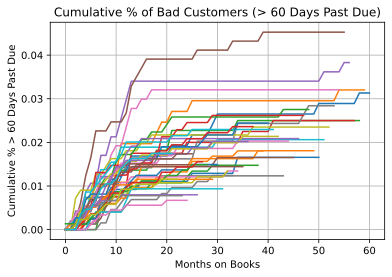

In [13]:
# plot vintage line chart
plt.rcParams['figure.facecolor'] = 'white'
vintage0 = vintage_wide.replace(0,np.nan)
lst = [i for i in range(0,61)]
vintage_wide[lst].T.plot(legend = False, grid = True, title = 'Cumulative % of Bad Customers (> 60 Days Past Due)')
#plt.axvline(30)
#plt.axvline(25)
#plt.axvline(20)
plt.xlabel('Months on Books')
plt.ylabel('Cumulative % > 60 Days Past Due')
plt.show()

## Observe Window Analysis
Because of two reasons, account cancellation and observe over, our observe on accounts will be truncated. Observe window is a significant parameter to be considered. If observe window is too short, users' behavior will not fully show off, which will bring unnecessary noise to our data.

In order to observe how many accounts increase as observe window extend, we plot this.

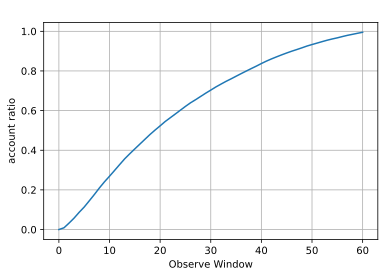

In [14]:
lst = []
for i in range(0,61):
    ratio = len(pivot_tb[pivot_tb['window'] < i]) / len(set(pivot_tb['ID']))
    lst.append(ratio)
    
pd.Series(lst).plot(legend = False, grid = True, title = ' ')
plt.xlabel('Observe Window')
plt.ylabel('account ratio')
plt.show()

We could see that a **60 months** observe window covers all appliers, while 20 months window contains about **52% records**.

In [15]:
def calculate_observe(credit, command):
    '''calculate observe window
    '''
    id_sum = len(set(pivot_tb['ID']))
    credit['status'] = 0
    exec(command)
    #credit.loc[(credit['STATUS'] == '4' )| (credit['STATUS'] == '5'), 'status'] = 1
    credit['month_on_book'] = credit['MONTHS_BALANCE'] - credit['open_month']
    minagg = credit[credit['status'] == 1].groupby('ID')['month_on_book'].min()
    minagg = pd.DataFrame(minagg)
    minagg['ID'] = minagg.index
    obslst = pd.DataFrame({'month_on_book':range(0,61), 'rate': None})
    lst = []
    for i in range(0,61):
        due = list(minagg[minagg['month_on_book']  == i]['ID'])
        lst.extend(due)
        obslst.loc[obslst['month_on_book'] == i, 'rate'] = len(set(lst)) / id_sum 
    return obslst['rate']

command = "credit.loc[(credit['STATUS'] == '0') | (credit['STATUS'] == '1') | (credit['STATUS'] == '2') | (credit['STATUS'] == '3' )| (credit['STATUS'] == '4' )| (credit['STATUS'] == '5'), 'status'] = 1"   
morethan1 = calculate_observe(credit, command)
command = "credit.loc[(credit['STATUS'] == '1') | (credit['STATUS'] == '2') | (credit['STATUS'] == '3' )| (credit['STATUS'] == '4' )| (credit['STATUS'] == '5'), 'status'] = 1"   
morethan30 = calculate_observe(credit, command)
command = "credit.loc[(credit['STATUS'] == '2') | (credit['STATUS'] == '3' )| (credit['STATUS'] == '4' )| (credit['STATUS'] == '5'), 'status'] = 1"
morethan60 = calculate_observe(credit, command)
command = "credit.loc[(credit['STATUS'] == '3' )| (credit['STATUS'] == '4' )| (credit['STATUS'] == '5'), 'status'] = 1"
morethan90 = calculate_observe(credit, command)
command = "credit.loc[(credit['STATUS'] == '4' )| (credit['STATUS'] == '5'), 'status'] = 1"
morethan120 = calculate_observe(credit, command)
command = "credit.loc[(credit['STATUS'] == '5'), 'status'] = 1"
morethan150 = calculate_observe(credit, command)

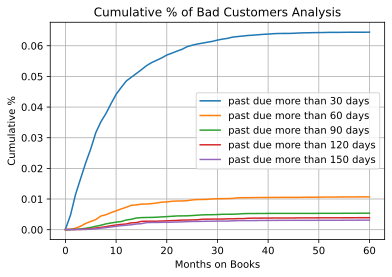

In [16]:
obslst = pd.DataFrame({'past due more than 30 days': morethan30,
                       'past due more than 60 days': morethan60,
                       'past due more than 90 days': morethan90,
                       'past due more than 120 days': morethan120,
                       'past due more than 150 days': morethan150
                        })

obslst.plot(grid = True, title = 'Cumulative % of Bad Customers Analysis')
plt.xlabel('Months on Books')
plt.ylabel('Cumulative %')
plt.show()

This plot could be seen as a average (across open-month) version of vintage plot. 
For longer past due date, it needs longer observe window. 
For example,**more than 150 days past due needs at least 5 months until first bad customer appears**. 
For most situation, a 20-months observe window could cover most bad customer. However, For 30 days past due, we could see that after 30 months on books, there still are new bad customer join in the list. 
**So a 20 MOB observe window will be appropriate. Those who exists shorter than the observe window should be excluded from our analysis, thus you could see I deleted users whose observe window less than 20 on last section (the window could be changed).**

## Overall Past-due Ratio

Calculating overall past-due rate. Respectively, we analyze 1 day past due, 20 days past due, 60 days past due, 90 days past due, 120 days past due, 150 days past due. This analysis could help us to define who are bad customers. We could see that almost 87% users have past due more than 1 day, which is too common, thus it's inappropriate to be a standard. What about 150 days overdue? Only 0.4% of accounts appear to past due that long. If we use that, we will left many bad customers in our scrutiny. A table like that will help you to determine what will be the most suitable standard of bad customers.

In [18]:
def calculate_rate(pivot_tb, command): 
    '''calculate bad customer rate
    '''
    credit0['status'] = None
    exec(command) # excuate input code
    sumagg = credit0.groupby('ID')['status'].agg(sum)
    pivot_tb = pd.merge(pivot_tb, sumagg, on = 'ID', how = 'left')
    pivot_tb.loc[pivot_tb['status'] > 1, 'status'] = 1
    rate = pivot_tb['status'].sum() / len(pivot_tb)
    return round(rate, 5)

command = "credit0.loc[(credit0['STATUS'] == '0') | (credit0['STATUS'] == '1') | (credit0['STATUS'] == '2') | (credit0['STATUS'] == '3' )| (credit0['STATUS'] == '4' )| (credit0['STATUS'] == '5'), 'status'] = 1"   
morethan1 = calculate_rate(pivot_tb, command)
command = "credit0.loc[(credit0['STATUS'] == '1') | (credit0['STATUS'] == '2') | (credit0['STATUS'] == '3' )| (credit0['STATUS'] == '4' )| (credit0['STATUS'] == '5'), 'status'] = 1"   
morethan30 = calculate_rate(pivot_tb, command)
command = "credit0.loc[(credit0['STATUS'] == '2') | (credit0['STATUS'] == '3' )| (credit0['STATUS'] == '4' )| (credit0['STATUS'] == '5'), 'status'] = 1"
morethan60 = calculate_rate(pivot_tb, command)
command = "credit0.loc[(credit0['STATUS'] == '3' )| (credit0['STATUS'] == '4' )| (credit0['STATUS'] == '5'), 'status'] = 1"
morethan90 = calculate_rate(pivot_tb, command)
command = "credit0.loc[(credit0['STATUS'] == '4' )| (credit0['STATUS'] == '5'), 'status'] = 1"
morethan120 = calculate_rate(pivot_tb, command)
command = "credit0.loc[(credit0['STATUS'] == '5'), 'status'] = 1"
morethan150 = calculate_rate(pivot_tb, command)

summary_dt = pd.DataFrame({'situation':['past due more than 1 day',
                               'past due more than 30 days',
                               'past due more than 60 days',
                               'past due more than 90 days',
                               'past due more than 120 days',
                               'past due more than 150 days'],
                      'bad customer ratio':[morethan1,
                               morethan30,
                               morethan60,
                               morethan90, 
                               morethan120,
                               morethan150, 
                      ]})
summary_dt

,situation,bad customer ratio
0,past due more than 1 day,0.87054
1,past due more than 30 days,0.11634
2,past due more than 60 days,0.01450
3,past due more than 90 days,0.00720
4,past due more than 120 days,0.00528
5,past due more than 150 days,0.00424


# Summary

Here shows some EDA on credit_record table, including **vintage analysis**, bad customer definition and observe window analysis. For credit card application data analysis, the response variable sometimes not clear, thus we need to extract information from credit record. This notebook does not contain all possible methods for sure. There definitly has more methods, I expect more valuable analysis based on this data :)

## Survival Analysis

        ID  month_on_book  truncate
0  5001713             21         0
1  5001715             59         0
2  5001717             21         0
3  5001718             38         0
4  5001719             42         0


<AxesSubplot:xlabel='timeline'>

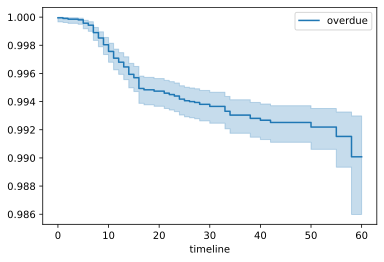

In [19]:
credit['truncate'] = credit.groupby('ID')['status'].transform('max')
truncate = credit.loc[credit['truncate']==1,]
not_trunc = credit.loc[credit['truncate']==0,]

dt1 = not_trunc.groupby('ID').agg({'month_on_book': ['max'],
                            'truncate':['max']
                           })
dt1.reset_index(inplace = True)
dt1.columns = ['ID','month_on_book','truncate']
dt2 = truncate.loc[truncate['status']==1,].groupby('ID').agg({'month_on_book': ['min'],
                            'truncate':['max']
                           })
dt2.reset_index(inplace = True)
dt2.columns = ['ID','month_on_book','truncate'] 
dt = dt1.append(dt2)

print(dt.head())

kmf = KaplanMeierFitter()
kmf.fit(dt['month_on_book'], event_observed=dt['truncate'], label='overdue')
kmf.plot()

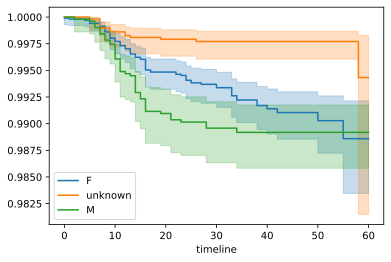

In [20]:
application = application[['ID', 'CODE_GENDER', 'FLAG_OWN_CAR', 'NAME_EDUCATION_TYPE','NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE']]
dt = pd.merge(dt, application, on = 'ID', how = 'left')
dt.fillna('unknown',inplace=True)

def plot_km(dt, timevar, truncate, groupby):
    '''plot km by subgroup
    '''
    plt.rcParams['figure.facecolor'] = 'white'
    kmf = KaplanMeierFitter()
    t = np.linspace(0, 60, 61)
    for i in dt[groupby].value_counts().index:
        kmf.fit(dt[dt[groupby] == i][timevar], event_observed=dt[dt[groupby] == i][truncate], timeline=t, label=i)
        ax = kmf.plot()

plot_km(dt, 'month_on_book', 'truncate', 'CODE_GENDER')

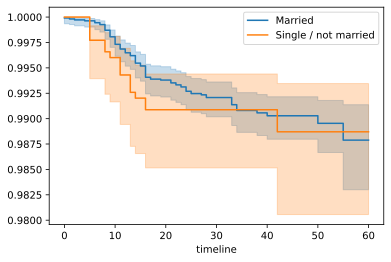

In [21]:
kmf = KaplanMeierFitter()
t = np.linspace(0, 60, 61)
kmf.fit(dt[dt['NAME_FAMILY_STATUS'] == 'Married']['month_on_book'], event_observed=dt[dt['NAME_FAMILY_STATUS'] == 'Married']['truncate'], timeline=t, label="Married")
ax = kmf.plot()

kmf.fit(dt[dt['NAME_FAMILY_STATUS'] == 'Single / not married']['month_on_book'], event_observed=dt[dt['NAME_FAMILY_STATUS'] == 'Single / not married']['truncate'], timeline=t, label="Single / not married")
ax = kmf.plot()